In [108]:
# Import libraries and dependencies

import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import os
import pandas as pd
import alpaca_trade_api.rest as tradeapi
import datetime as dt
import holoviews as hv
from prophet import Prophet

In [109]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [110]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [111]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2012-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["ETH"]



df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

ticker_df = df_ticker.drop(['trade_count', 'vwap', 'symbol'], axis=1)

ticker_df2 = df_ticker.drop(['trade_count', 'vwap', 'symbol', 'volume', 'low', 'high', 'open'], axis=1)

# Display sample data
ticker_df



,open,high,low,close,volume
timestamp,,,,,
2015-12-01 05:00:00+00:00,28.57,28.935,28.24,28.44,172987
2015-12-02 05:00:00+00:00,28.41,28.950,28.30,28.83,162629
2015-12-03 05:00:00+00:00,28.87,28.900,28.02,28.09,122823
2015-12-04 05:00:00+00:00,28.12,28.780,27.99,28.74,74512
2015-12-07 05:00:00+00:00,28.58,28.700,28.28,28.46,104457
...,...,...,...,...,...
2021-08-09 04:00:00+00:00,23.69,24.147,23.30,23.86,381884
2021-08-10 04:00:00+00:00,24.15,25.880,24.00,25.26,700875
2021-08-11 04:00:00+00:00,25.38,26.670,25.13,26.48,403335


In [112]:
ticker_df2

,close
timestamp,
2015-12-01 05:00:00+00:00,28.44
2015-12-02 05:00:00+00:00,28.83
2015-12-03 05:00:00+00:00,28.09
2015-12-04 05:00:00+00:00,28.74
2015-12-07 05:00:00+00:00,28.46
...,...
2021-08-09 04:00:00+00:00,23.86
2021-08-10 04:00:00+00:00,25.26
2021-08-11 04:00:00+00:00,26.48


In [113]:
# Filter the date index and close columns
signals_df = ticker_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

In [114]:
# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
timestamp,,
2015-12-02 05:00:00+00:00,28.83,0.013713
2015-12-03 05:00:00+00:00,28.09,-0.025668
2015-12-04 05:00:00+00:00,28.74,0.023140
2015-12-07 05:00:00+00:00,28.46,-0.009743
2015-12-08 05:00:00+00:00,27.86,-0.021082


,close,Actual Returns
timestamp,,
2021-08-09 04:00:00+00:00,23.86,0.002521
2021-08-10 04:00:00+00:00,25.26,0.058676
2021-08-11 04:00:00+00:00,26.48,0.048298
2021-08-12 04:00:00+00:00,26.60,0.004532
2021-08-13 04:00:00+00:00,26.30,-0.011278


In [115]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
timestamp,,,,
2016-04-26 04:00:00+00:00,34.42,0.110323,31.9175,28.4456
2016-04-27 04:00:00+00:00,34.41,-0.000291,32.7125,28.5014
2016-04-28 04:00:00+00:00,33.93,-0.013949,33.4400,28.5598
2016-04-29 04:00:00+00:00,34.04,0.003242,34.2000,28.6128
2016-05-02 04:00:00+00:00,34.31,0.007932,34.1725,28.6713


,close,Actual Returns,SMA_Fast,SMA_Slow
timestamp,,,,
2021-08-09 04:00:00+00:00,23.86,0.002521,23.6875,27.7381
2021-08-10 04:00:00+00:00,25.26,0.058676,24.1775,27.7005
2021-08-11 04:00:00+00:00,26.48,0.048298,24.8500,27.6790
2021-08-12 04:00:00+00:00,26.60,0.004532,25.5500,27.6619
2021-08-13 04:00:00+00:00,26.30,-0.011278,26.1600,27.6478


In [116]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
timestamp,,,,,
2016-04-26 04:00:00+00:00,34.42,0.110323,31.9175,28.4456,1.0
2016-04-27 04:00:00+00:00,34.41,-0.000291,32.7125,28.5014,-1.0
2016-04-28 04:00:00+00:00,33.93,-0.013949,33.4400,28.5598,-1.0
2016-04-29 04:00:00+00:00,34.04,0.003242,34.2000,28.6128,1.0
2016-05-02 04:00:00+00:00,34.31,0.007932,34.1725,28.6713,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
timestamp,,,,,
2021-08-09 04:00:00+00:00,23.86,0.002521,23.6875,27.7381,1.0
2021-08-10 04:00:00+00:00,25.26,0.058676,24.1775,27.7005,1.0
2021-08-11 04:00:00+00:00,26.48,0.048298,24.8500,27.6790,1.0
2021-08-12 04:00:00+00:00,26.60,0.004532,25.5500,27.6619,1.0
2021-08-13 04:00:00+00:00,26.30,-0.011278,26.1600,27.6478,-1.0


In [117]:
signals_df['Signal'].value_counts()

 1.0    711
-1.0    625
Name: Signal, dtype: int64

In [118]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
timestamp,,,,,,
2016-04-26 04:00:00+00:00,34.42,0.110323,31.9175,28.4456,1.0,NaN
2016-04-27 04:00:00+00:00,34.41,-0.000291,32.7125,28.5014,-1.0,-0.000291
2016-04-28 04:00:00+00:00,33.93,-0.013949,33.4400,28.5598,-1.0,0.013949
2016-04-29 04:00:00+00:00,34.04,0.003242,34.2000,28.6128,1.0,-0.003242
2016-05-02 04:00:00+00:00,34.31,0.007932,34.1725,28.6713,1.0,0.007932


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
timestamp,,,,,,
2021-08-09 04:00:00+00:00,23.86,0.002521,23.6875,27.7381,1.0,0.002521
2021-08-10 04:00:00+00:00,25.26,0.058676,24.1775,27.7005,1.0,0.058676
2021-08-11 04:00:00+00:00,26.48,0.048298,24.8500,27.6790,1.0,0.048298
2021-08-12 04:00:00+00:00,26.60,0.004532,25.5500,27.6619,1.0,0.004532
2021-08-13 04:00:00+00:00,26.30,-0.011278,26.1600,27.6478,-1.0,-0.011278


<AxesSubplot:xlabel='timestamp'>

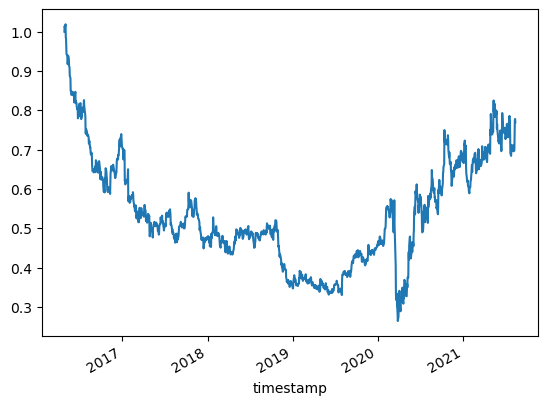

In [119]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [120]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
timestamp,,
2016-04-27 04:00:00+00:00,31.9175,28.4456
2016-04-28 04:00:00+00:00,32.7125,28.5014
2016-04-29 04:00:00+00:00,33.4400,28.5598
2016-05-02 04:00:00+00:00,34.2000,28.6128
2016-05-03 04:00:00+00:00,34.1725,28.6713


In [121]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    711
-1.0    625
Name: Signal, dtype: int64

In [122]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2016-04-27 04:00:00+00:00


In [123]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2016-07-27 04:00:00+00:00


In [124]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
timestamp,,
2016-04-27 04:00:00+00:00,31.9175,28.4456
2016-04-28 04:00:00+00:00,32.7125,28.5014
2016-04-29 04:00:00+00:00,33.4400,28.5598
2016-05-02 04:00:00+00:00,34.2000,28.6128
2016-05-03 04:00:00+00:00,34.1725,28.6713


In [125]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
timestamp,,
2016-07-28 04:00:00+00:00,35.2700,32.3970
2016-07-29 04:00:00+00:00,34.8225,32.4405
2016-08-01 04:00:00+00:00,34.6725,32.4919
2016-08-02 04:00:00+00:00,34.3575,32.5392
2016-08-03 04:00:00+00:00,34.5075,32.5897


In [126]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [127]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values

svm_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [128]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.59      0.02      0.04       595
         1.0       0.53      0.99      0.69       676

    accuracy                           0.54      1271
   macro avg       0.56      0.50      0.37      1271
weighted avg       0.56      0.54      0.39      1271



In [129]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df["Actual Returns"] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2016-07-28 04:00:00+00:00,1.0,0.004703,0.004703
2016-07-29 04:00:00+00:00,1.0,0.016091,0.016091
2016-08-01 04:00:00+00:00,1.0,-0.006623,-0.006623
2016-08-02 04:00:00+00:00,1.0,0.003478,0.003478
2016-08-03 04:00:00+00:00,1.0,-0.005199,-0.005199


,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2021-08-09 04:00:00+00:00,1.0,0.002521,0.002521
2021-08-10 04:00:00+00:00,1.0,0.058676,0.058676
2021-08-11 04:00:00+00:00,1.0,0.048298,0.048298
2021-08-12 04:00:00+00:00,1.0,0.004532,0.004532
2021-08-13 04:00:00+00:00,1.0,-0.011278,-0.011278


<AxesSubplot:xlabel='timestamp'>

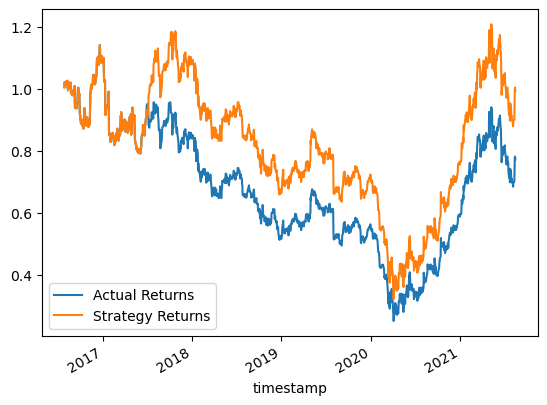

In [130]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()


In [131]:
# Import a new classifier from SKLearn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Initiate the model instance
model = LogisticRegression()


In [132]:
# Fit the model using the training data

model.fit(X_train_scaled, y_train)
# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values

pred

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [133]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_training_report = classification_report(y_test, pred)

# Print the classification report

print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.77      0.58       595
         1.0       0.54      0.24      0.33       676

    accuracy                           0.49      1271
   macro avg       0.50      0.50      0.46      1271
weighted avg       0.51      0.49      0.45      1271



In [134]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df2 = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df2['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_df2['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df2['Strategy Returns'] = predictions_df2["Actual Returns"] * predictions_df2["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())


,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2016-07-28 04:00:00+00:00,1.0,0.004703,0.004703
2016-07-29 04:00:00+00:00,1.0,0.016091,0.016091
2016-08-01 04:00:00+00:00,1.0,-0.006623,-0.006623
2016-08-02 04:00:00+00:00,1.0,0.003478,0.003478
2016-08-03 04:00:00+00:00,1.0,-0.005199,-0.005199


,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2021-08-09 04:00:00+00:00,1.0,0.002521,0.002521
2021-08-10 04:00:00+00:00,1.0,0.058676,0.058676
2021-08-11 04:00:00+00:00,1.0,0.048298,0.048298
2021-08-12 04:00:00+00:00,1.0,0.004532,0.004532
2021-08-13 04:00:00+00:00,1.0,-0.011278,-0.011278


<AxesSubplot:xlabel='timestamp'>

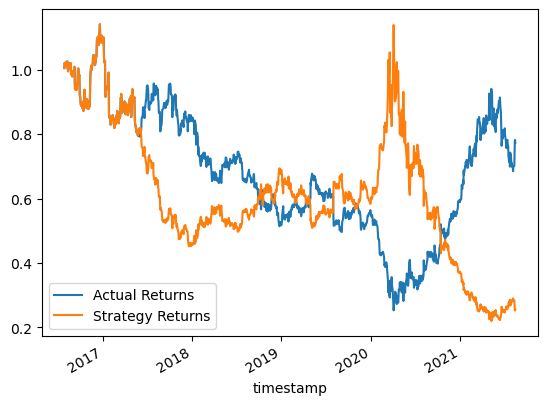

In [135]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df2[["Actual Returns", "Strategy Returns"]]).cumprod().plot()